## Script's Goals

This script is used to pre-process the transcriptomic data. The genes across each dataset will be align to enable a consistent comparison. The number of genes that we will put in the machine learning model will be reduce to avoid the overfitting and to simplify the model. Normalization will be applied to scale data across different datasets and harmonize their distributions. Additionally, batch correction will be performed to account for differences between health statuses.

 ## Import packages

In [1]:
import pandas as pd
import anndata as ad
import scanpy as sc
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.sparse import issparse

/home/mc202900/.conda/envs/my_env01/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/mc202900/.conda/envs/my_env01/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/mc202900/.conda/envs/my_env01/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/mc202900/.conda/envs/my_env01/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/mc202900/.conda/envs/my_env01/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: 

## Define Function

In [2]:
def charge_tsv(path):
    # function to load a tsv_file in a pandas table
    df = pd.read_csv(path, sep='\t', header=0, index_col=0)
    return df

In [3]:
def construct_ad(dico):
    # function to create an anndata object containing all the dataset and the batch and the role (train/test) in obs.
    
    adata_list= []
    
    # Iterate over the dictionary and create AnnData objects
    for name, df in filtered_datasets.items():
        # Extract batch and role from the name
        batch = name
        role = name.split('_')[1]
        status = name.split('_')[0]

        # Create an AnnData object
        adata = ad.AnnData(df)

        # Add 'batch' and 'role' columns to the obs dataframe
        adata.obs['batch'] = batch
        adata.obs['role'] = role
        adata.obs['status'] = status

        # Append the AnnData object to the list
        adata_list.append(adata)

    # Combine all AnnData objects into one
    combined_adata = ad.concat(adata_list)
    return combined_adata

In [4]:
def preprocess(adata, batch_correction, N_GENES):
    # Separate data in train and test
    adata_train = adata[adata.obs["role"] == "train"].copy()
    adata_test = adata[adata.obs["role"] == "test"].copy()
    
    def preprocess_split(adata_split):
        # Step 1: Normalize for library size per sample
        sc.pp.normalize_total(adata_split, target_sum=1e4)

        # Step 2: Log1p transformation
        sc.pp.log1p(adata_split)

        return adata_split

    # Normalize separately train and test
    adata_train = preprocess_split(adata_train)
    adata_test = preprocess_split(adata_test)
    
    # Combine anndata objects
    adata_list= []
    adata_list.append(adata_train)
    adata_list.append(adata_test)
    combined_adata = ad.concat(adata_list)
    
    # Step 3: Select highly variable genes accounting for batch effect
    sc.pp.highly_variable_genes(combined_adata, n_top_genes=N_GENES, batch_key='batch')

    # Step 4: Keep only the highly variable genes
    combined_adata = combined_adata[:, combined_adata.var['highly_variable']]

    # Optionnal Step 5: Batch correction (sur les données train uniquement)
    if batch_correction:
        sce.pp.combat(combined_adata, key='batch')

    return combined_adata

In [5]:
def Do_PCA(adata):
    
    # Vérification que adata.X existe et n'est pas None
    if adata.X is None:
        raise ValueError("La matrice X est vide ou non définie dans l'objet AnnData.")
        
    # Conversion en matrice dense si nécessaire
    if issparse(adata.X):
        X = adata.X.toarray()
    else:
        X = adata.X
    
    # Vérification que la matrice X contient des données valides
    if adata.X.size == 0:
        raise ValueError("La matrice X est vide. Vérifiez vos données.")

    # Application de la PCA avec scikit-learn
    n_components = 10  # Nombre de composantes principales à conserver
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    # Stockage des résultats dans 'obsm' (observation matrix)
    adata.obsm["X_PCA"] = X_pca

    # Optionnel : stocker les valeurs propres et les scores d'explication de la variance
    adata.uns["PCA_variance_ratio"] = pca.explained_variance_ratio_
    adata.uns["PCA_variance"] = pca.explained_variance_

    print("PCA terminée. Les résultats ont été stockés dans adata.obsm['X_PCA'].")
    return adata

## Load the data

In [6]:
healthy_train = charge_tsv("/home/mc202900/datasets_scienta/healthy_train_data.tsv")
healthy_test = charge_tsv("/home/mc202900/datasets_scienta/healthy_test_data.tsv")
ra_train = charge_tsv("/home/mc202900/datasets_scienta/ra_train_data.tsv")
ra_test = charge_tsv("/home/mc202900/datasets_scienta/ra_test_data.tsv")
sle_train = charge_tsv("/home/mc202900/datasets_scienta/sle_train_data.tsv")
sle_test = charge_tsv("/home/mc202900/datasets_scienta/sle_test_data.tsv")

In [7]:
datasets = {
    "healthy_train": healthy_train,
    "healthy_test": healthy_test,
    "ra_train": ra_train,
    "ra_test": ra_test,
    "sle_train" : sle_train,
    "sle_test" : sle_test
}

## Select only the genes shared by all dataframes

In [8]:
# 1. Find the common columns across all DataFrames
common_columns = set(datasets['healthy_train'].columns)
for df in datasets.values():
    common_columns.intersection_update(df.columns)

# 2. Create a new dictionary with filtered DataFrames, keeping only the common columns
filtered_datasets = {name: df[list(common_columns)] for name, df in datasets.items()}

In [9]:
for name, df in filtered_datasets.items():
    row, col = df.shape
    print(f'The dataset {name} has {row} rows and {col} columns')

The dataset healthy_train has 302 rows and 24403 columns
The dataset healthy_test has 100 rows and 24403 columns
The dataset ra_train has 1587 rows and 24403 columns
The dataset ra_test has 330 rows and 24403 columns
The dataset sle_train has 1332 rows and 24403 columns
The dataset sle_test has 465 rows and 24403 columns


## Construct an anndata object containing all the datasets, select the 350 most variables genes, normalize and batch correct.

In [10]:
# Construct the anndata object containing all the datasets
adata = construct_ad(filtered_datasets)

# Pre-process the data
adata_no_batch = preprocess(adata, False, 500)


/tmp/ipykernel_1965525/3866679058.py:23: ImplicitModificationWarning: Setting element `.obsm['X_PCA']` of view, initializing view as actual.
  adata.obsm["X_PCA"] = X_pca


PCA terminée. Les résultats ont été stockés dans adata.obsm['X_PCA'].


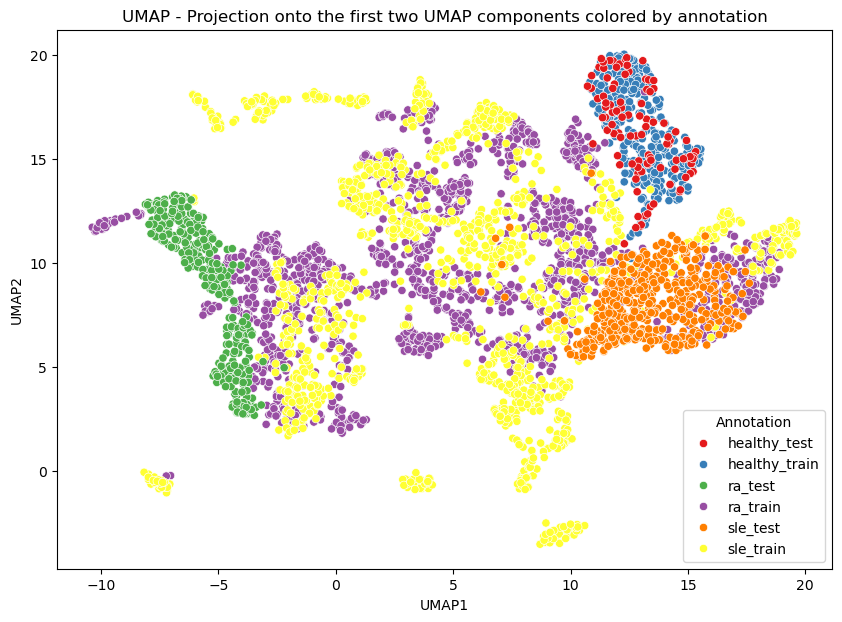

In [11]:
#Application d'une PCA aux données d'expression pour réduire les distances entre les données sur l'UMAP,
#et ainsi avoir une meilleure visualisation
adata_no_batch = Do_PCA(adata_no_batch)

# Load the transcription dataset
X = adata_no_batch.obsm["X_PCA"]
y = adata_no_batch.obs["batch"]

# Dimensionality reduction with UMAP
reducer = umap.UMAP(
    n_components=2,     # Réduction en 2 dimensions
    n_neighbors=40,     # Augmente le voisinage pour capturer plus de structures globales
    min_dist=0.8,       # Distance minimale plus grande pour une distribution plus compacte
    metric='cosine'     # Utilise la similarité cosinus au lieu de la distance euclidienne
)
X_umap = reducer.fit_transform(X)

# Convert the UMAP result to a DataFrame for easier data manipulation
df_umap = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])
df_umap['Label'] = y.values  # Ensure y is correctly assigned

# Scatter plot of the first two UMAP components colored by annotation
plt.figure(figsize=(10, 7))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='Label', palette='Set1', data=df_umap)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP - Projection onto the first two UMAP components colored by annotation')
plt.legend(title='Annotation')
plt.show()

In [12]:
adata_no_batch.write_h5ad("/home/mc202900/outputs/Dataset_PP_500")